# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

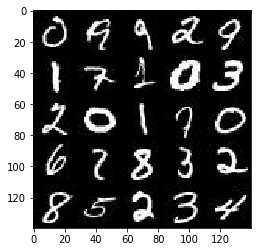

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

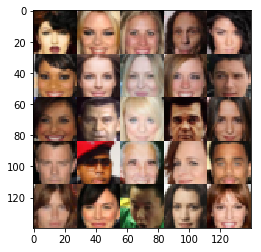

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs_images')
    z_data = tf.placeholder(tf.float32, (None, z_dim), 'z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.1
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.1
    
        h1 = tf.layers.dense(z, 2 * 2 * 512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)
        ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        ))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
    ))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    colls = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [coll for coll in colls if coll.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    n_images = 25
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1678... Generator Loss: 4.1411
Epoch 1/2... Discriminator Loss: 0.0195... Generator Loss: 4.7741
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 3.6704
Epoch 1/2... Discriminator Loss: 0.5532... Generator Loss: 1.5849
Epoch 1/2... Discriminator Loss: 0.1401... Generator Loss: 6.1019
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 5.7431
Epoch 1/2... Discriminator Loss: 0.5899... Generator Loss: 5.5431
Epoch 1/2... Discriminator Loss: 2.5959... Generator Loss: 7.9667
Epoch 1/2... Discriminator Loss: 0.3784... Generator Loss: 1.7971
Epoch 1/2... Discriminator Loss: 0.1075... Generator Loss: 4.3588


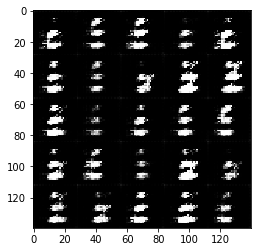

Epoch 1/2... Discriminator Loss: 0.1350... Generator Loss: 5.4023
Epoch 1/2... Discriminator Loss: 0.1179... Generator Loss: 3.3649
Epoch 1/2... Discriminator Loss: 3.1147... Generator Loss: 13.0196
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 2.5259
Epoch 1/2... Discriminator Loss: 0.1981... Generator Loss: 2.7191
Epoch 1/2... Discriminator Loss: 0.5414... Generator Loss: 7.2586
Epoch 1/2... Discriminator Loss: 0.1532... Generator Loss: 5.0646
Epoch 1/2... Discriminator Loss: 0.1353... Generator Loss: 3.4658
Epoch 1/2... Discriminator Loss: 0.3023... Generator Loss: 2.6998
Epoch 1/2... Discriminator Loss: 0.1774... Generator Loss: 4.1806


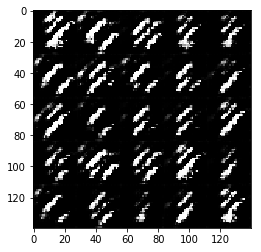

Epoch 1/2... Discriminator Loss: 0.1640... Generator Loss: 3.5554
Epoch 1/2... Discriminator Loss: 0.1915... Generator Loss: 6.6355
Epoch 1/2... Discriminator Loss: 0.7039... Generator Loss: 1.6210
Epoch 1/2... Discriminator Loss: 0.5566... Generator Loss: 4.6714
Epoch 1/2... Discriminator Loss: 0.2594... Generator Loss: 6.7085
Epoch 1/2... Discriminator Loss: 0.0894... Generator Loss: 3.2974
Epoch 1/2... Discriminator Loss: 0.0116... Generator Loss: 6.0796
Epoch 1/2... Discriminator Loss: 0.0655... Generator Loss: 6.0965
Epoch 1/2... Discriminator Loss: 0.0512... Generator Loss: 4.2846
Epoch 1/2... Discriminator Loss: 0.4461... Generator Loss: 1.7062


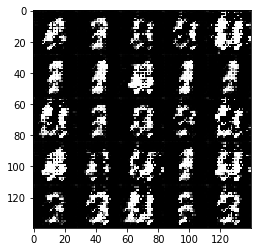

Epoch 1/2... Discriminator Loss: 1.8863... Generator Loss: 0.3437
Epoch 1/2... Discriminator Loss: 0.1678... Generator Loss: 2.9853
Epoch 1/2... Discriminator Loss: 0.3800... Generator Loss: 2.3377
Epoch 1/2... Discriminator Loss: 0.1527... Generator Loss: 3.3053
Epoch 1/2... Discriminator Loss: 0.1939... Generator Loss: 3.9491
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 2.3826
Epoch 1/2... Discriminator Loss: 0.1870... Generator Loss: 2.6359
Epoch 1/2... Discriminator Loss: 0.1862... Generator Loss: 5.0364
Epoch 1/2... Discriminator Loss: 1.0069... Generator Loss: 9.3534
Epoch 1/2... Discriminator Loss: 0.1565... Generator Loss: 2.6704


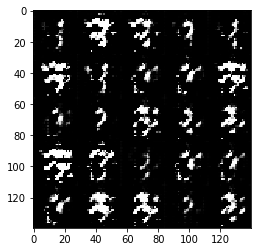

Epoch 1/2... Discriminator Loss: 0.2048... Generator Loss: 8.3217
Epoch 1/2... Discriminator Loss: 0.1176... Generator Loss: 4.6365
Epoch 1/2... Discriminator Loss: 1.1054... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 1.8911... Generator Loss: 7.8210
Epoch 1/2... Discriminator Loss: 0.5538... Generator Loss: 3.3329
Epoch 1/2... Discriminator Loss: 0.3258... Generator Loss: 2.1338
Epoch 1/2... Discriminator Loss: 0.3356... Generator Loss: 2.8435
Epoch 1/2... Discriminator Loss: 0.3909... Generator Loss: 2.9008
Epoch 1/2... Discriminator Loss: 0.3160... Generator Loss: 2.8050
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 1.8824


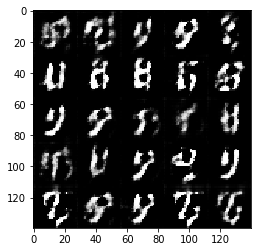

Epoch 1/2... Discriminator Loss: 0.4565... Generator Loss: 4.2069
Epoch 1/2... Discriminator Loss: 0.3636... Generator Loss: 2.5097
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 7.7045
Epoch 1/2... Discriminator Loss: 0.1605... Generator Loss: 4.1830
Epoch 1/2... Discriminator Loss: 0.3080... Generator Loss: 2.6870
Epoch 1/2... Discriminator Loss: 0.4185... Generator Loss: 6.4813
Epoch 1/2... Discriminator Loss: 0.2023... Generator Loss: 3.8409
Epoch 1/2... Discriminator Loss: 0.4624... Generator Loss: 4.6604
Epoch 1/2... Discriminator Loss: 0.4001... Generator Loss: 3.2859
Epoch 1/2... Discriminator Loss: 0.3068... Generator Loss: 2.3068


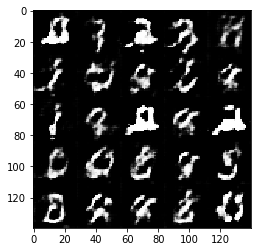

Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 1.3459
Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 2.2666
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 1.5621
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 2.5390
Epoch 2/2... Discriminator Loss: 0.7458... Generator Loss: 3.8695
Epoch 2/2... Discriminator Loss: 0.5561... Generator Loss: 3.8304
Epoch 2/2... Discriminator Loss: 0.5140... Generator Loss: 4.0426
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 1.2426
Epoch 2/2... Discriminator Loss: 0.6899... Generator Loss: 4.0312


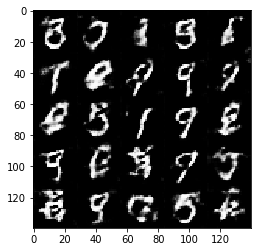

Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 1.4787
Epoch 2/2... Discriminator Loss: 0.3264... Generator Loss: 3.2889
Epoch 2/2... Discriminator Loss: 0.5074... Generator Loss: 1.9300
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.6156
Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 2.8418
Epoch 2/2... Discriminator Loss: 0.4741... Generator Loss: 2.6069
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 0.9321
Epoch 2/2... Discriminator Loss: 0.4603... Generator Loss: 2.9641
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 2.1766


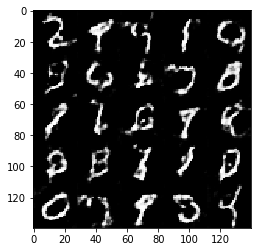

Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.4631
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 0.7544
Epoch 2/2... Discriminator Loss: 0.5711... Generator Loss: 1.6589
Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 4.7240
Epoch 2/2... Discriminator Loss: 1.5112... Generator Loss: 4.9122
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.4801
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 0.8641
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 4.6680
Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.9770... Generator Loss: 0.2389


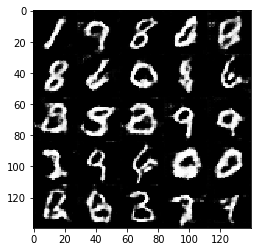

Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 1.0575
Epoch 2/2... Discriminator Loss: 2.4846... Generator Loss: 5.1070
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.2129
Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 2.6490
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 1.1455
Epoch 2/2... Discriminator Loss: 0.5995... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 0.7506... Generator Loss: 1.8355
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.6886
Epoch 2/2... Discriminator Loss: 2.0356... Generator Loss: 4.2617


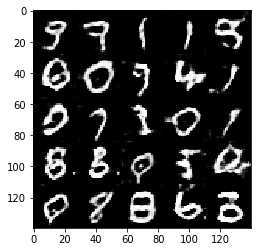

Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 0.9641
Epoch 2/2... Discriminator Loss: 0.6020... Generator Loss: 2.6003
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 0.6915... Generator Loss: 1.5719
Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 1.4998
Epoch 2/2... Discriminator Loss: 1.5515... Generator Loss: 0.4028
Epoch 2/2... Discriminator Loss: 0.7261... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 2.6182
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 2.0074


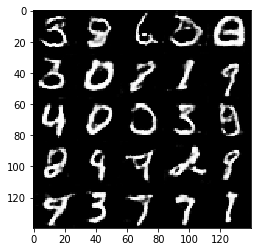

Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 1.4584
Epoch 2/2... Discriminator Loss: 0.8939... Generator Loss: 0.9566
Epoch 2/2... Discriminator Loss: 0.7300... Generator Loss: 1.3262
Epoch 2/2... Discriminator Loss: 1.4363... Generator Loss: 0.4029
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 1.3948
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.0393
Epoch 2/2... Discriminator Loss: 1.9267... Generator Loss: 0.2682
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 0.7531


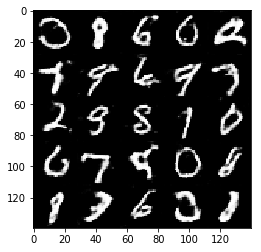

In [15]:
batch_size = 100
z_dim = 100
learning_rate = 0.002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0809... Generator Loss: 7.0539
Epoch 1/1... Discriminator Loss: 0.2841... Generator Loss: 8.7208
Epoch 1/1... Discriminator Loss: 0.0472... Generator Loss: 3.2314
Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 6.7935
Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 9.2107
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 4.8159
Epoch 1/1... Discriminator Loss: 0.3202... Generator Loss: 5.5459
Epoch 1/1... Discriminator Loss: 5.0777... Generator Loss: 13.4166
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 3.2937
Epoch 1/1... Discriminator Loss: 0.1409... Generator Loss: 2.3215


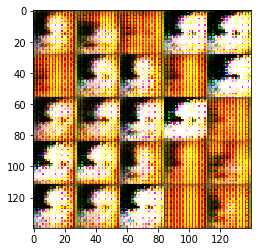

Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 3.8513
Epoch 1/1... Discriminator Loss: 0.0725... Generator Loss: 5.2105
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 2.2137
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 1.4664
Epoch 1/1... Discriminator Loss: 6.0740... Generator Loss: 12.2755
Epoch 1/1... Discriminator Loss: 2.4238... Generator Loss: 0.1552
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 2.7094
Epoch 1/1... Discriminator Loss: 0.2136... Generator Loss: 5.1621
Epoch 1/1... Discriminator Loss: 0.1286... Generator Loss: 2.9101
Epoch 1/1... Discriminator Loss: 0.2686... Generator Loss: 4.9241


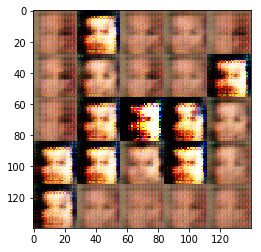

Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 2.6779
Epoch 1/1... Discriminator Loss: 0.2838... Generator Loss: 4.1628
Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 9.4087... Generator Loss: 15.6296
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 2.5843
Epoch 1/1... Discriminator Loss: 0.2254... Generator Loss: 2.7778
Epoch 1/1... Discriminator Loss: 0.2114... Generator Loss: 2.5402
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 4.3886
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.4385


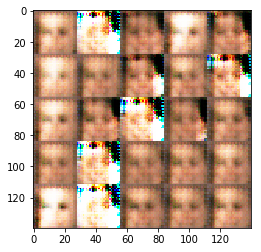

Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 3.1527
Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 2.2901
Epoch 1/1... Discriminator Loss: 1.6467... Generator Loss: 0.2956
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.6557
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 2.5087... Generator Loss: 0.2504
Epoch 1/1... Discriminator Loss: 2.0189... Generator Loss: 3.1464
Epoch 1/1... Discriminator Loss: 0.2800... Generator Loss: 2.5023


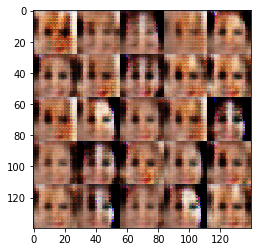

Epoch 1/1... Discriminator Loss: 3.0732... Generator Loss: 0.2061
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.2694
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 2.9046
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 1.9635
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 3.1769
Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 1.8440
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.5754


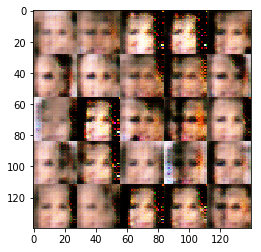

Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 2.0465
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.4871
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.9074
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 2.5472
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 3.2170
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.2888
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.0288


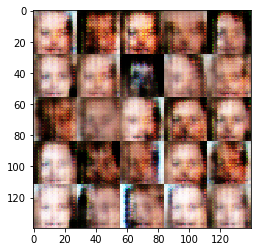

Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.7296
Epoch 1/1... Discriminator Loss: 2.2364... Generator Loss: 0.1786
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 3.2171
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 1.5013
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 0.8966


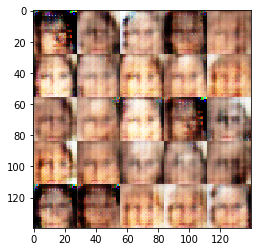

Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 1.4359
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 2.0111
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 1.7026
Epoch 1/1... Discriminator Loss: 2.7303... Generator Loss: 5.3958
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 1.6710... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.2917


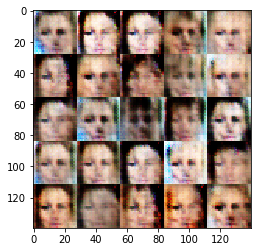

Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.5287
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.5489
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.4874
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 2.1092


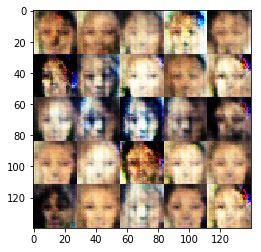

Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.4750
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 2.0931
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.6550
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 1.8482
Epoch 1/1... Discriminator Loss: 1.6776... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.5886


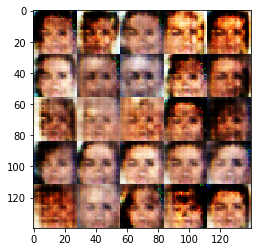

Epoch 1/1... Discriminator Loss: 1.7827... Generator Loss: 0.2793
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.9593
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.8459
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.2757
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.2115
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.5783


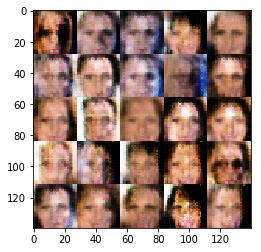

Epoch 1/1... Discriminator Loss: 2.3297... Generator Loss: 0.2389
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 3.1377
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 3.7388
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 2.0132
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 2.2284
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.8124
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5312


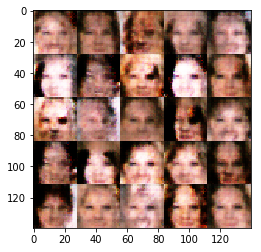

Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 2.4817
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 2.0699
Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 1.6823
Epoch 1/1... Discriminator Loss: 1.7642... Generator Loss: 0.3134
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.7929
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 1.9003
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.7105
Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 2.1862... Generator Loss: 0.1739


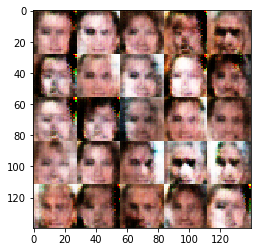

Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.5048
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.9684
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 3.0137
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.8064
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 2.8832
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.7632
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.5567


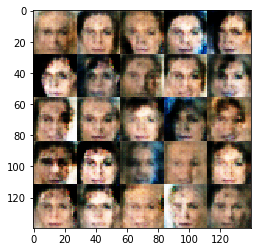

Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 3.1628... Generator Loss: 6.5193
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.8143
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.5212
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.7805


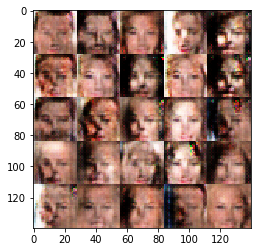

Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.9408
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 2.6684
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 2.3427
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 2.3352
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 2.5259
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 2.2228
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.1304


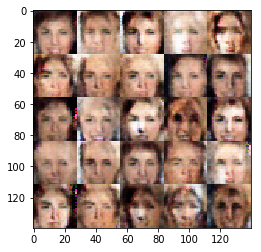

Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.9561... Generator Loss: 4.6418
Epoch 1/1... Discriminator Loss: 1.7085... Generator Loss: 4.1035
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.7395
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 2.9951
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.8838
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.3748
Epoch 1/1... Discriminator Loss: 0.6198... Generator Loss: 2.1965


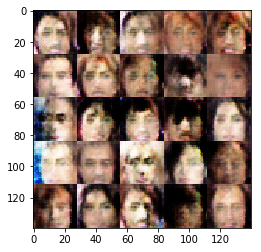

Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 2.2700
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.6370
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.7115
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 1.6182
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 4.7938
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.0887


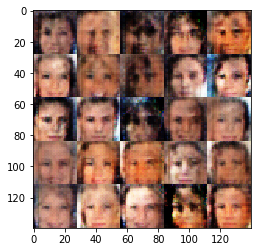

Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 2.0509
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 2.2943
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 3.7598
Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 1.4005
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 3.9322
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.5852
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.5028


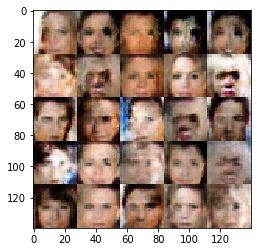

Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 2.0440
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 2.2473
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 2.1992
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 2.2825
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 1.8518
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 2.1300
Epoch 1/1... Discriminator Loss: 1.7203... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 2.0547


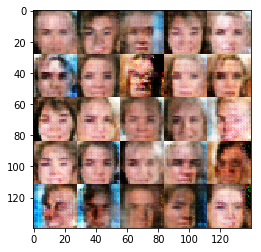

Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 2.3179
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.1382


In [17]:
batch_size = 100
z_dim = 100
learning_rate = 0.002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.